<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC3
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Recurrent Neural Networks

En esta práctica implementaremos redes neuronales recurrentes para generar música.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# 0. Contexto y referencias

Esta PEC está basada en el siguiente [artículo de investigación](https://arxiv.org/pdf/1711.07682.pdf), aunque por motivos de extensión no podremos pasar por todos los puntos del artículo.

La primera etapa de esta PEC será leer y entender la idea general de este trabajo. El artículo os da acceso al código original con el que se ha llevado a cabo el trabajo y en el que además esta basado gran parte del código que aquí os adjuntamos, aunque por la complejidad y extensión del código no os recomendamos que sumergáis demasiado en él.

La PEC consta de una etapa de ***interpretación de los datos*** (un paso vital en todo proyecto real), donde se pedirá reproducir una gráfica del artículo. Luego ***entrenaremos*** una red LSTM para generar acordes a partir de archivos MIDI. Finalmente, usaremos la capa de ***embedding*** de la red entrenada para hacer una proyección de los acordes en 2D y visualizar el concepto de [word2vec](https://en.wikipedia.org/wiki/Word2vec).

Además de este fichero os hemos adjuntado un archivo comprimido con una estructura de datos similar a la usada en el artículo y que os recomendamos (por vuestro bien) que no modifiquéis :). Allí encontraréis una carpeta llamada *data* donde se encuentra la base de datos que usaremos y otros ficheros que os facilitamos con datos de redes ya entrenadas (en la carpeta *models*)

# Sección 1. Análisis Exploratorio de los datos [1.5 pts]

## 1.1 Importación de módulos y paquetes necesarios

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# añade el path a tu directorio
%cd /content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022

/content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
from collections import Counter
import collections
import pandas as pd


## 1.2 Carga de imágenes en dataset

In [4]:
import cv2

In [5]:
from inspect import classify_class_attrs
ROOT_PATH = '/content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022'

def load_data(path: str):
  """
  """
  data = []
  for folder in os.listdir(path):
    print('Processing folder:' + folder)
    data.append(load_models(folder))
  return data

def load_models(folder):
  train = []
  test = []
  valid = []
  train = load_images(folder, 'train')
  test = load_images(folder, 'test')
  valid = load_images(folder, 'valid')

  return np.asarray(train, dtype=object), np.asarray(test, dtype=object), np.asarray(valid, dtype=object)

def load_images(folder, model):
  data = []
  path = os.path.join(folder, model)
  for classifier in os.listdir(path):
    print('Processing class:' + classifier)
    path = os.path.join(folder, model, classifier)
    for img in os.listdir(path):
      #print('Processing image:' + img)
      img_absolute_path = os.path.join(path, img)
      image_data_temp = cv2.imread(img_absolute_path)
      data.append([image_data_temp, classifier])
  return data


train, test, valid = load_models('Fold0')

Processing class:normal
Processing class:abnormal
Processing class:normal
Processing class:abnormal
Processing class:abnormal
Processing class:normal


In [6]:
train.shape, test.shape, valid.shape 

((1379, 2), (174, 2), (154, 2))

In [7]:
train[0][0].shape, test[0][0].shape, valid[0][0].shape 

((224, 224, 3), (224, 224, 3), (224, 224, 3))

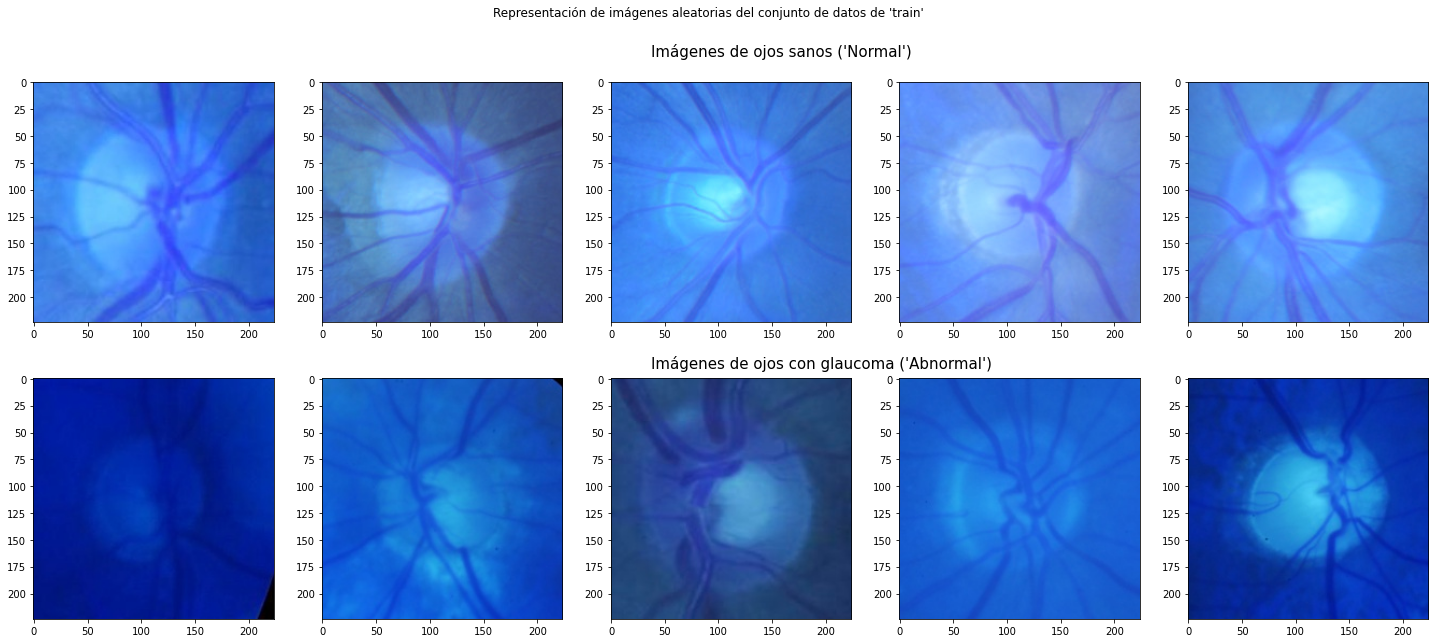

In [8]:
# Adjust proper figsize for scaling up the images
f, big_axes = plt.subplots(2,5, figsize=(25,10))

normal = train[np.where(train[:, 1] == 'normal')]
n = 0
for j in range(0,5):
  big_axes[0,j].imshow(normal[n][0])
  n = n + 1

abnormal = train[np.where(train[:, 1] == 'abnormal')]
n = 0
for j in range(0,5):
  big_axes[1,j].imshow(abnormal[n][0])
  n = n + 1

plt.text(-500, -300, 'Imágenes de ojos sanos (\'Normal\')', fontsize=15)
plt.text(-500, -10, 'Imágenes de ojos con glaucoma (\'Abnormal\')', fontsize=15)
plt.suptitle('Representación de imágenes aleatorias del conjunto de datos de \'train\'')

plt.show()


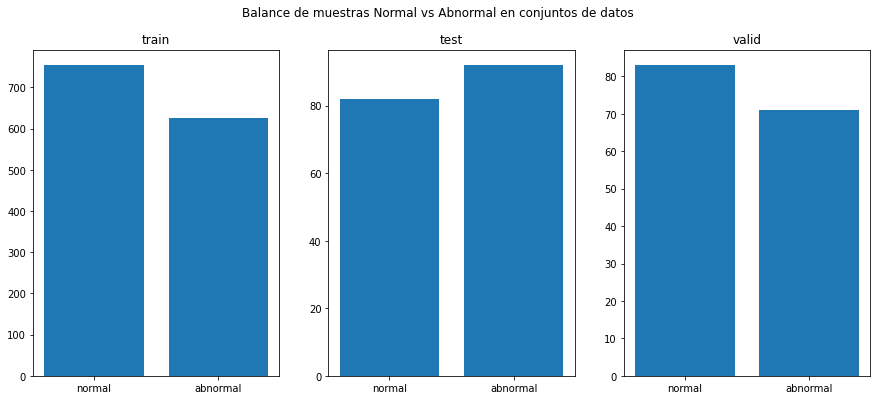

In [9]:
f, axarr = plt.subplots(1,3, figsize=(15,6))

classes = ['normal', 'abnormal']
counts = [normal.shape[0], abnormal.shape[0]]
axarr[0].bar(classes, counts)
axarr[0].set_title('train')

normal = test[np.where(test[:, 1] == 'normal')]
abnormal = test[np.where(test[:, 1] == 'abnormal')]
counts = [normal.shape[0], abnormal.shape[0]]
axarr[1].bar(classes, counts)
axarr[1].set_title('test')

normal = valid[np.where(valid[:, 1] == 'normal')]
abnormal = valid[np.where(valid[:, 1] == 'abnormal')]
counts = [normal.shape[0], abnormal.shape[0]]
axarr[2].bar(classes, counts)
axarr[2].set_title('valid')

plt.suptitle('Balance de muestras Normal vs Abnormal en conjuntos de datos')
plt.show()

# Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)

Ahora volvemos al artículo y aplicaremos el procesado de datos. Buscar dentro del fichero *data_processing_functions.py* la función que se encarga de llevar a cabo todo el procesado de datos y llamarla desde aquí

This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

In [10]:
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import timeit
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad


In [11]:
IMG_SIZE = 224
def build_model():

    # En caso de querer preprocesar las imagenes, hacer algo parecido a lo comentado.
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    #model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    model = EfficientNetB0(include_top=False, weights="imagenet")
    inputs = model.input
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    # Fully connected layer with 1 class for binary classification
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
 
    model = keras.Model(inputs, outputs, name="EfficientNet")
    return model


In [12]:
model = build_model()
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                      

In [13]:
data_dir = os.path.join('Fold0', 'train')
batch_size=32
train_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  shuffle=True)

data_dir = os.path.join('Fold0', 'valid')
batch_size=32
valid_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  shuffle=True)

Found 1379 files belonging to 2 classes.
Found 154 files belonging to 2 classes.


In [ ]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd7fe7a2bd0> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd7fd91ec90> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7fd7fd8b9e50> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fd7fcea0790> False
<keras.layers.convolutional.Conv2D object at 0x7fd7fceba0d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd7fce80dd0> False
<keras.layers.core.activation.Activation object at 0x7fd7fd7c4f50> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fd7f0a8af50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd7f0a9b590> False
<keras.layers.core.activation.Activation object at 0x7fd7f0a9b4d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd7f0a3ba10> False
<keras.layers.core.reshape.Reshape object at 0x7fd7f0a49750> False
<keras.layers.convolutional.Conv2D object at 0x7

In [ ]:
# Compile
optimizer = SGD(learning_rate=0.01)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Entrenar el modelo
t0 = timeit.default_timer()
mfit = model.fit(train_ds, epochs=100, batch_size=128, validation_data=valid_ds)
training_time_ann = timeit.default_timer() - t0

Epoch 1/100
44/44 [==============================] - 11s 119ms/step - loss: 0.6166 - accuracy: 0.6860 - val_loss: 0.5788 - val_accuracy: 0.7532
Epoch 2/100
44/44 [==============================] - 4s 88ms/step - loss: 0.5056 - accuracy: 0.7585 - val_loss: 0.5350 - val_accuracy: 0.7468
Epoch 3/100
44/44 [==============================] - 4s 87ms/step - loss: 0.4717 - accuracy: 0.7788 - val_loss: 0.5175 - val_accuracy: 0.7597
Epoch 4/100
44/44 [==============================] - 4s 87ms/step - loss: 0.4267 - accuracy: 0.8078 - val_loss: 0.4818 - val_accuracy: 0.7662
Epoch 5/100
44/44 [==============================] - 4s 88ms/step - loss: 0.4066 - accuracy: 0.8115 - val_loss: 0.4724 - val_accuracy: 0.7922
Epoch 6/100
44/44 [==============================] - 4s 88ms/step - loss: 0.3967 - accuracy: 0.8151 - val_loss: 0.4462 - val_accuracy: 0.7857
Epoch 7/100
44/44 [==============================] - 4s 88ms/step - loss: 0.3890 - accuracy: 0.8180 - val_loss: 0.4592 - val_accuracy: 0.7987
Epoc

In [ ]:
#Function to compute several models changing Optimizers and learning rate
def compute(model, train_ds, valid_ds):
  rates = [0.001, 0.01, 0.1]
  optimizers = []
  result = []
  for r in range(len(rates)):
    optimizers.append([SGD(learning_rate=rates[r]), "SGD", rates[r]])
    optimizers.append([Adadelta(learning_rate=rates[r]), "Adadelta", rates[r]])
    optimizers.append([Adagrad(learning_rate=rates[r]), "Adagrad", rates[r]])
    optimizers.append([Adam(learning_rate=rates[r]), "Adam", rates[r]])
 
  for i in range(len(optimizers)):
    optimizer = optimizers[i]
    # Not sure if this helps reseting the model
    model = build_model()
    model.compile(optimizer[0], "binary_crossentropy", metrics=["accuracy"])
    t0 = timeit.default_timer()
    history = model.fit(train_ds, epochs=20, batch_size=64, verbose=1,
                        validation_data=valid_ds)
    training_time = timeit.default_timer() - t0
    avg_accuracy = np.mean(history.history['accuracy'])
    result.append([optimizer[1], optimizer[2], training_time, avg_accuracy])
  return result

In [ ]:
#Compute models
c = compute(model, train_ds, valid_ds)

Epoch 1/20
44/44 [==============================] - 11s 114ms/step - loss: 0.9348 - accuracy: 0.4989 - val_loss: 0.7210 - val_accuracy: 0.5000
Epoch 2/20
44/44 [==============================] - 4s 85ms/step - loss: 0.9071 - accuracy: 0.4931 - val_loss: 0.7107 - val_accuracy: 0.5325
Epoch 3/20
44/44 [==============================] - 4s 85ms/step - loss: 0.8698 - accuracy: 0.5221 - val_loss: 0.7002 - val_accuracy: 0.5584
Epoch 4/20
44/44 [==============================] - 4s 83ms/step - loss: 0.8325 - accuracy: 0.5337 - val_loss: 0.6881 - val_accuracy: 0.5455
Epoch 5/20
44/44 [==============================] - 4s 84ms/step - loss: 0.8391 - accuracy: 0.5395 - val_loss: 0.6747 - val_accuracy: 0.5714
Epoch 6/20
44/44 [==============================] - 4s 84ms/step - loss: 0.8231 - accuracy: 0.5475 - val_loss: 0.6590 - val_accuracy: 0.5909
Epoch 7/20
44/44 [==============================] - 4s 84ms/step - loss: 0.7933 - accuracy: 0.5635 - val_loss: 0.6440 - val_accuracy: 0.6364
Epoch 8/20


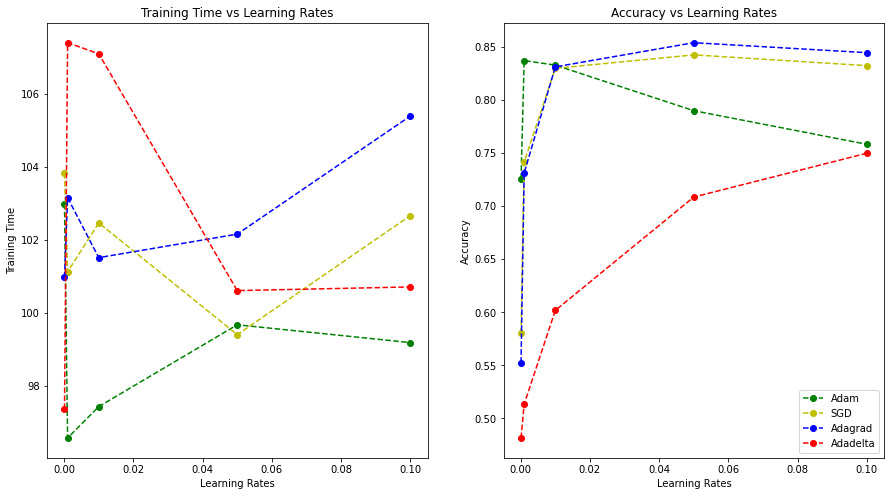

In [ ]:
#Plots

# distribuir el resultado en variables más legibles
opts = []
times = []
rates = []
acc = []
for i in range(len(c)):
  m = c[i]
  opts.append(m[0])
  rates.append(m[1])
  times.append(m[2]) 
  acc.append(m[3])

# Variables para las coordenadas de las lineas
adam_rates = []
adam_accuracy = []
adam_times = []
sgd_rates = []
sgd_accuracy = []
sgd_times = []
adagrad_rates = []
adagrad_accuracy = []
adagrad_times = []
adadelta_rates = []
adadelta_accuracy = []
adadelta_times = []

# Transformacion de variables
for i in range(len(times)):
  if opts[i] == 'Adam':
    adam_rates.append(rates[i])
    adam_times.append(times[i])
    adam_accuracy.append(acc[i])
  elif opts[i] == 'SGD':
    sgd_rates.append(rates[i])
    sgd_times.append(times[i])
    sgd_accuracy.append(acc[i])
  elif opts[i] == 'Adagrad':
    adagrad_rates.append(rates[i])
    adagrad_times.append(times[i])
    adagrad_accuracy.append(acc[i])
  elif opts[i] == 'Adadelta':
    adadelta_rates.append(rates[i])
    adadelta_times.append(times[i]) 
    adadelta_accuracy.append(acc[i])

fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(adam_rates, adam_times, linestyle='--', marker='o', color='g', label='Adam')
ax[0].plot(sgd_rates, sgd_times, linestyle='--', marker='o', color='y', label='SGD')
ax[0].plot(adagrad_rates, adagrad_times, linestyle='--', marker='o', color='b', label='Adagrad')
ax[0].plot(adadelta_rates, adadelta_times, linestyle='--', marker='o', color='r', label='Adadelta')
ax[0].set_title('Training Time vs Learning Rates')
ax[0].set_xlabel('Learning Rates')
ax[0].set_ylabel('Training Time')

ax[1].plot(adam_rates, adam_accuracy, linestyle='--', marker='o', color='g', label='Adam')
ax[1].plot(sgd_rates, sgd_accuracy, linestyle='--', marker='o', color='y', label='SGD')
ax[1].plot(adagrad_rates, adagrad_accuracy, linestyle='--', marker='o', color='b', label='Adagrad')
ax[1].plot(adadelta_rates, adadelta_accuracy, linestyle='--', marker='o', color='r', label='Adadelta')
ax[1].set_title('Accuracy vs Learning Rates')
ax[1].set_xlabel('Learning Rates')
ax[1].set_ylabel('Accuracy')
plt.legend()
plt.show()

De los gráficos anteriores, utilizaremos el optimizador SGD con un learning rate de 0.05 dado que, junto con Adagrad, presenta los mejores resultados y tiene un menor tiempo de entrenamiento. Ahora, buscamos número óptimo de épocas con el optimizador seleccionado.

In [14]:
# Plot del training loss y el accuracy
def plot_loss_accuracy(n_epochs, mfit):
  loss = mfit.history['loss']
  val_loss = mfit.history['val_loss']

  accuracy = mfit.history['accuracy']
  val_accuracy = mfit.history['val_accuracy']

  epochs = range(0,n_epochs)
  plt.subplots(figsize=(15,10))
  plt.plot(epochs, loss, 'g', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')

  plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

  plt.title('Model Loss and Accuracy')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Total')
  plt.legend()
  plt.show()

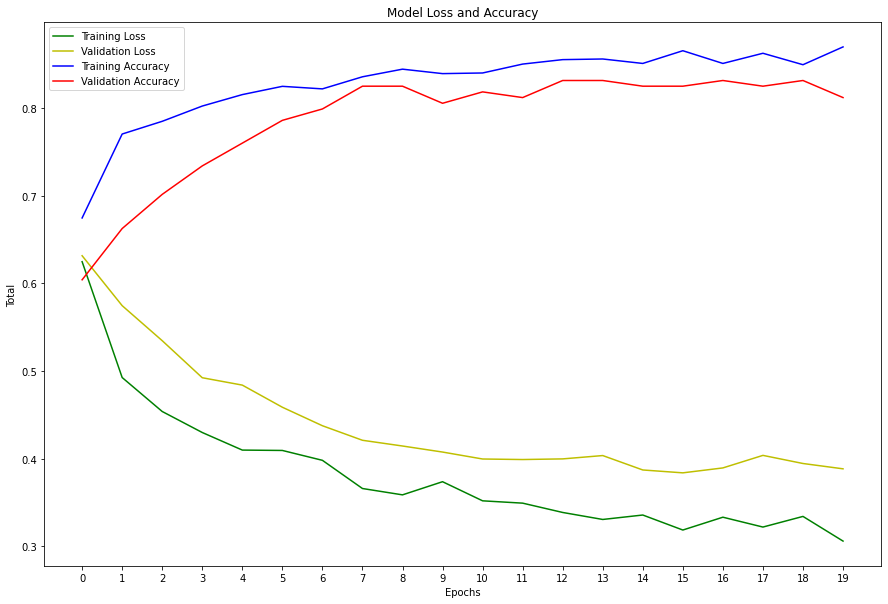

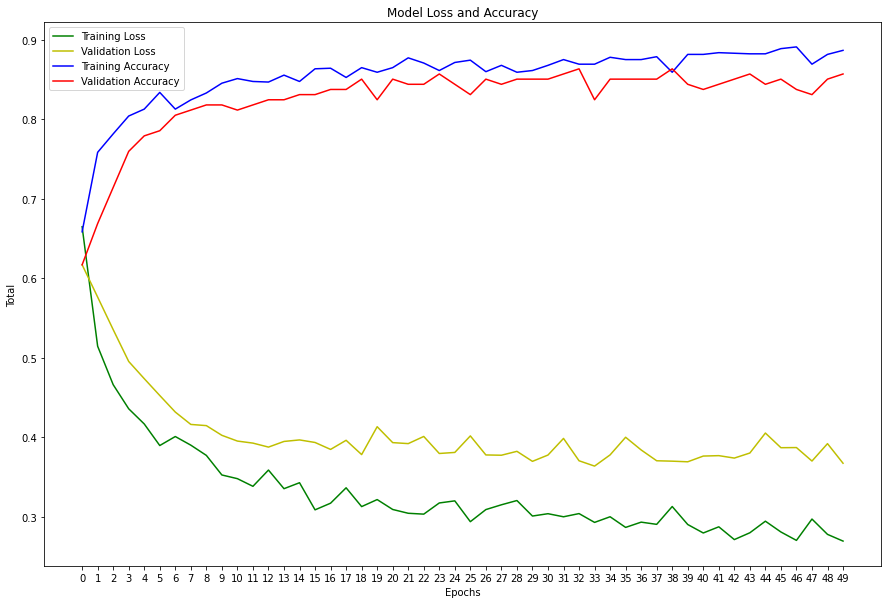

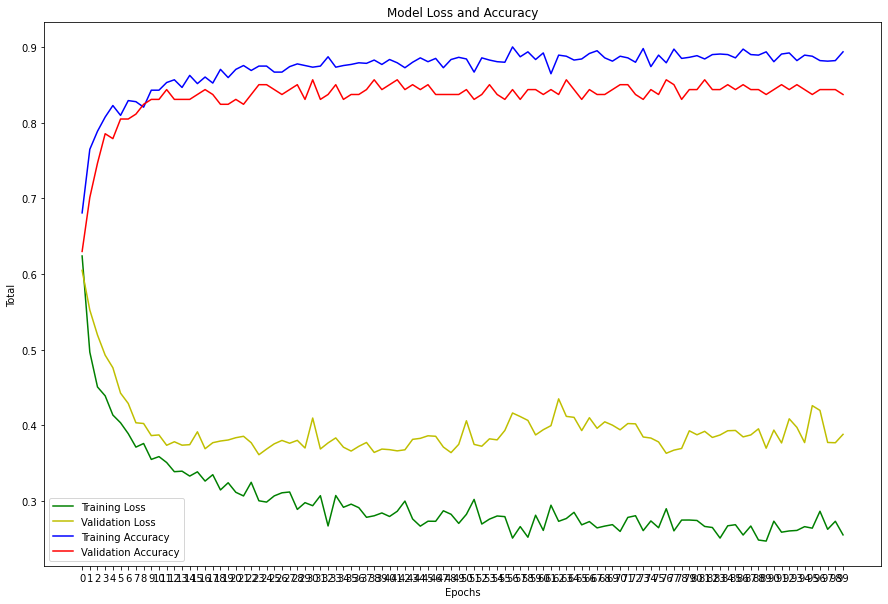

In [20]:
#Function to compute several models changing epochs
def compute_epochs(train_ds, valid_ds):
  epochs = [20, 50, 100]
 
  for i in range(len(epochs)):
    # Not sure if this helps reseting the model
    model = build_model()
    model.compile(SGD(learning_rate=0.01), "binary_crossentropy", metrics=["accuracy"])
    t0 = timeit.default_timer()
    history = model.fit(train_ds, epochs=epochs[i], batch_size=64, verbose=0,
                        validation_data=valid_ds)
    training_time = timeit.default_timer() - t0
    plot_loss_accuracy(epochs[i], history)
    avg_accuracy = np.mean(history.history['accuracy'])

compute_epochs(train_ds, valid_ds)